(16, 16)


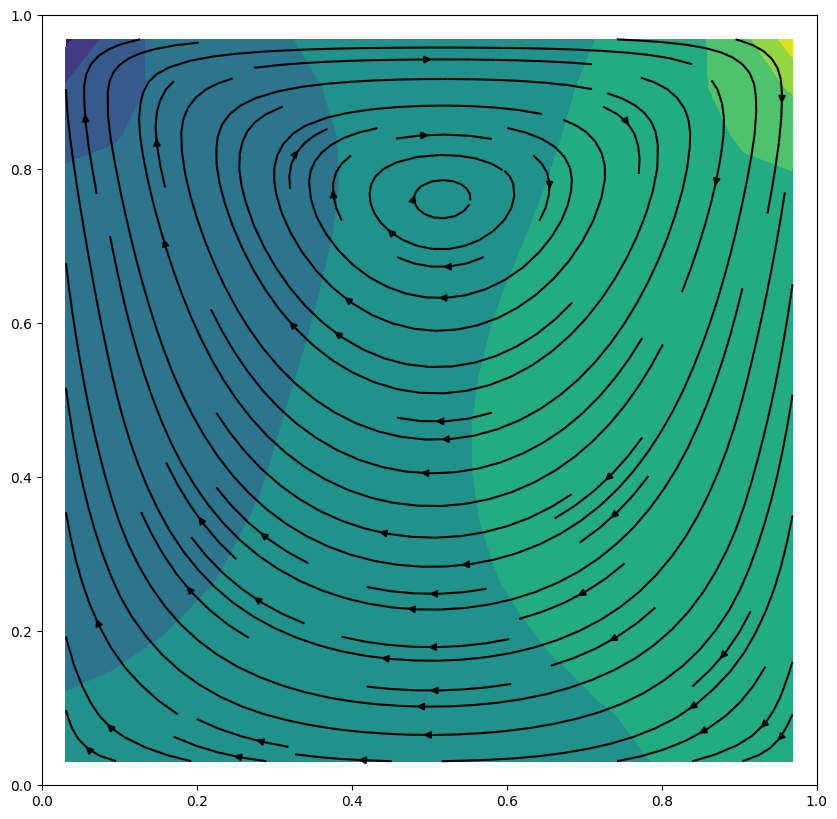

In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random

def create_A(N):
  A = np.zeros((N * N, N * N))
  counter_left = 0
  counter_right = N - 1
  for i in range(N * N):

    if (i < N):
      A[i][i] += 0
    else:
      A[i][i-N] -= 1
      A[i][i] += 1
      
    if (i > N * (N-1) - 1):
      A[i][i] += 0
    else:
      A[i][i+N] -= 1
      A[i][i] += 1

    if (i == counter_left): 
      counter_left += N
    else: 
      A[i][i-1] -= 1
      A[i][i] += 1

    if (i == counter_right):
      counter_right += N 
    else:
      A[i][i+1] -= 1
      A[i][i] += 1
  return A

def solve_uv(u_prev, v_prev, p_prev, N, dt, h, nu):
  u_new = np.zeros((N, N + 1)) #3 на 4
  v_new = np.zeros((N + 1, N)) #4 на 3
  for i in range (0, N):   # 0 1 2
    for j in range (1, N): # 1 2 3
      uc = u_prev[i][j]
      vwn = v_prev[i][j - 1]
      vne = v_prev[i][j]
      vws = v_prev[i + 1][j - 1]
      ves = v_prev[i + 1][j]
      
      if i == 0:
        un = 2 - uc
      else:
        un = u_prev[i - 1][j]
    
      if i == (N-1):
        us = - uc
      else:
        us = u_prev[i + 1][j]

      if j == (0):
        uw = - uc
      else:
        uw = u_prev[i][j - 1]

      if j == (N):
        ue = - uc
      else:
        ue = u_prev[i][j + 1]

      u_new[i, j] = uc - dt * (0.25 / h * ((uc + ue) * (uc + ue) - (uw + uc) * (uw + uc) - (vwn + vne) * (un + uc) + (vws + ves) * (us + uc)) + nu / (h ** 2) * (4 * uc - uw - ue - us - un) + (p_prev[i * N + j] - p_prev[i * N + j - 1] ) / h)
  
  for i in range (1, N):   # 0 1 2
    for j in range (0, N):
      vc = v_prev[i][j]
      vn = v_prev[i-1][j]
      vs = v_prev[i+1][j]
      uwn = u_prev[i-1][j]
      uws = u_prev[i][j]
      une = u_prev[i-1][j+1]
      ues = u_prev[i][j+1]

      if (j == 0):
        vw = - vc
      else:
        vw = v_prev[i][j-1]
      if (j == N - 1):
        ve = - vc
      else:        
        ve = v_prev[i][j+1]

      v_new[i, j] = vc - dt * (0.25 / h * ((une + ues) * (ve + vc) - (uwn + uws) * (vc + vw) - ((vn + vc))**  2 + ((vs + vc)) ** 2 ) + nu / h ** 2 * (4 * vc - vw - ve - vs - vn) + (p_prev[i * N + j] - p_prev[(i - 1) * N + j]) / h)
  return u_new, v_new

def div(u_new, v_new, h):
  b = np.zeros(N * N)
  for i in range (N):
    for j in range (N):
      b[i*N + j] = - h * (u_new[i][j + 1] - u_new[i][j] + v_new[i + 1][j] - v_new[i][j])
  return(b)

def solve_p(A, b):
  return np.linalg.solve(A, b)

def plot_solution(u, v, p, N, streamplot=True):
    u = (u[:, :-1] + u[:, 1:]) / 2
    v = (v[1:, :] + v[:-1, :]) / 2
    print(u.shape)
    u = u[::-1, ::]
    v = -v[::-1, ::]
    p=p.reshape((N,N))[::-1,::]
    x = np.arange(h / 2, 1, h)
    y = np.arange(h / 2, 1, h)
    # y = np.arange(-1, -self.h/2, self.h)
    grid_x, grid_y = np.meshgrid(x, y)
    fig = plt.figure(figsize=(10, 10))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.streamplot(grid_x, grid_y, u, v, color='black')
    # plt.title(f"N = {self.N}, Eps = {self.eps}, Nu = {self.nu}, dt = {dt}", fontsize=20)
    # plt.savefig('output.png')
    plt.contourf(grid_x, grid_y, p.reshape((N,N)))
    plt.show()

if __name__ == '__main__':
    L = 1
    N = 16
    # nu = 8.9 * (pow(10, -3)) #вязкость воды
    nu = 0.1
    eps = 0.01
    dt = 0.01

    t = 0
    T = 1

    h = L / N

    a = 0.8
    a_p = 0.85
    # eps_u = 0.02

    A = create_A(N)
    u_prev = np.zeros((N, N + 1))
    v_prev = np.zeros((N + 1, N))
    p_prev = np.zeros((N * N))
    cont = True
    # while cont or t < 0.2:
    while t < T:
      p_new = p_prev
      iter = 0
      norm_b = 100
      while norm_b > eps:
        u_new, v_new = solve_uv(u_prev, v_prev, p_new, N, dt, h, nu)
        b = div(u_new, v_new, h)
        norm_b = np.linalg.norm(b)
        if norm_b > eps:
          p_differ = solve_p(A, b/dt) 
          p_new = p_new + p_differ
          iter += 1
      # if np.linalg.norm(u_new - u_prev) * h / dt < eps_u and np.linalg.norm(v_new - v_prev) * h / dt < eps_u:
      #   cont = False
      # print(np.linalg.norm(u_new - u_prev)* h / dt)
      u_prev, v_prev = u_new, v_new
      p_prev = p_new

      # print("iter ", iter)
      # print('t: ', t)
      t += dt

    plot_solution(u_prev, v_prev, p_prev, N)  